In [26]:
load('M1_spikes.mat');

# Plots of spiking activity

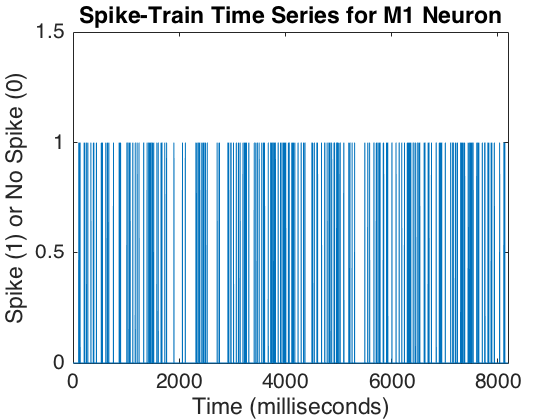

In [27]:
totalTime = max(T);
figure();plot(T,spikes);axis([0 totalTime 0 1.5]);
xlabel('Time (milliseconds)');ylabel('Spike (1) or No Spike (0)');
title('Spike-Train Time Series for M1 Neuron');

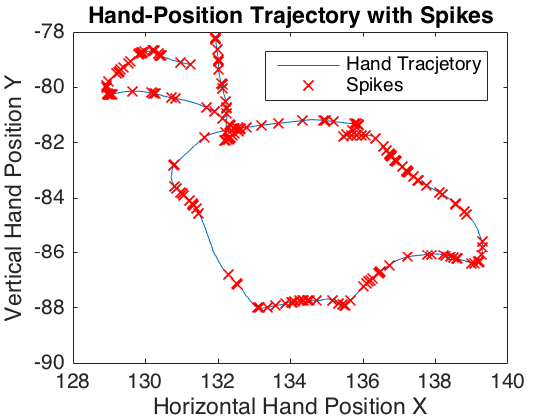

In [28]:
figure();plot(X,Y);hold on; 
for ii=1:totalTime
if spikes(ii) == 1
plot(X(ii),Y(ii),'rx');
end
end
xlabel('Horizontal Hand Position X');ylabel('Vertical Hand Position Y');
title('Hand-Position Trajectory with Spikes');
legend('Hand Tracjetory','Spikes');

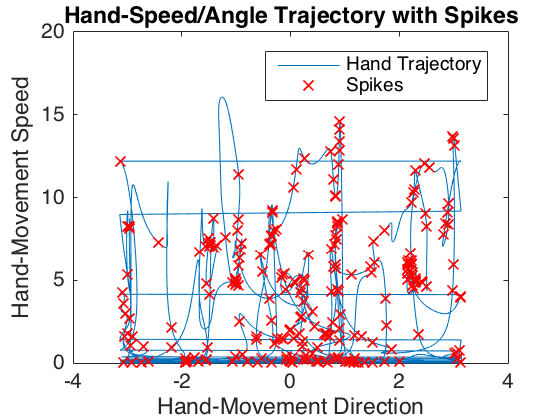

In [29]:
figure();plot(phi,V);hold on;
for ii=1:totalTime
if spikes(ii) == 1
plot(phi(ii),V(ii),'rx');
end
end
xlabel('Hand-Movement Direction');ylabel('Hand-Movement Speed');
title('Hand-Speed/Angle Trajectory with Spikes');
legend('Hand Trajectory','Spikes');

At this point, there is no obvious connection between spike times and hand trajectory for either position or velocity. There may be more spikes at a direction of about 1 radian and maybe again around 2.25 radians. Not shown: a plot of the spike times overlaid on the velocity in the X direction versus velocity in the Y direction similarly shows no clear relationship.

# Occupancy-Normalized Histogram

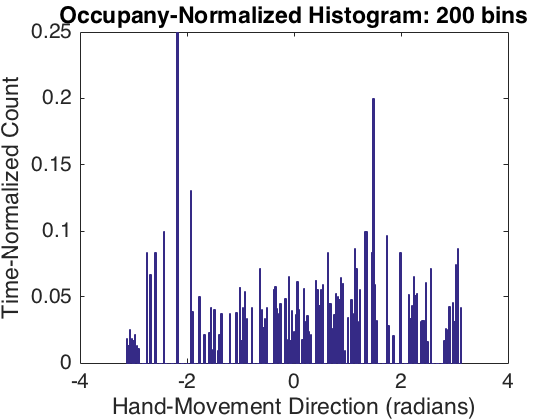

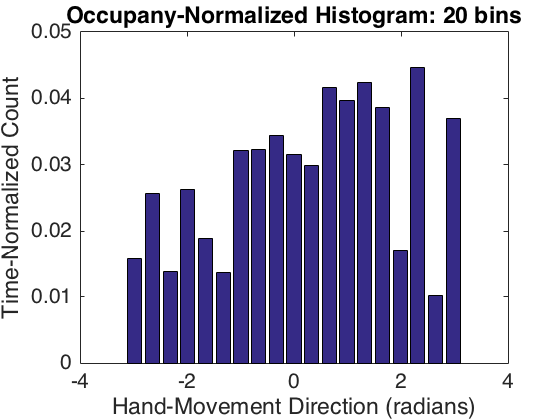

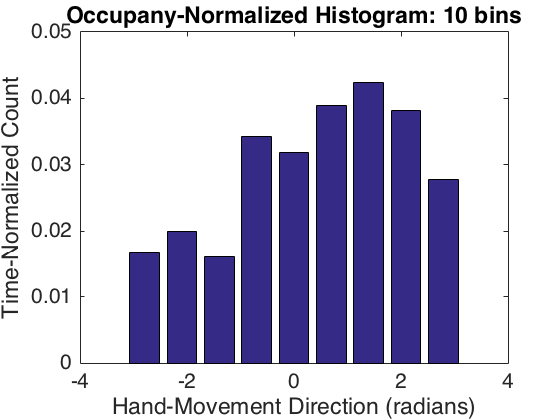

In [30]:
% occupancy-normalized histogram
%  time has been discretized to 1-ms bins and phi is given for each of those bins
%  the total amount of time spent in each hand-movement direction is just the number of time bins
%  for which the direction PHI = x  (x is a realization of PHI)

for numBins = [10,20,200]
possibleDirections = linspace(-pi,pi,numBins); % histogram bin edges
binCenters = (possibleDirections(1:end-1)+possibleDirections(2:end))./2;
timePerDirection = histcounts(phi,possibleDirections);

spikesPerDirection = zeros(size(timePerDirection));
for ii=1:length(phi)
    direction = phi(ii);
    whichBin = discretize(direction,possibleDirections);
    if spikes(ii) == 1
        spikesPerDirection(whichBin) = spikesPerDirection(whichBin)+1;
    end
end

timeNormalized = spikesPerDirection./timePerDirection;
figure();bar(binCenters,timeNormalized);
xlabel('Hand-Movement Direction (radians)');ylabel('Time-Normalized Count');
title(sprintf('Occupany-Normalized Histogram: %d bins',numBins));
end


The estimated direction of hand movement in which this neuron is most likely to fire is ~ +1 radians. However, there may be some periodicity in preferred direction as the values increase around ~ -2 radians in the histogram with 200 bins. Perhaps, the model requires an extra parameter in the cosine to account for different periodicities, e.g. cos(gamma*phi(t)-phi_preferred).

# Likelihood of the Data For the Given Model

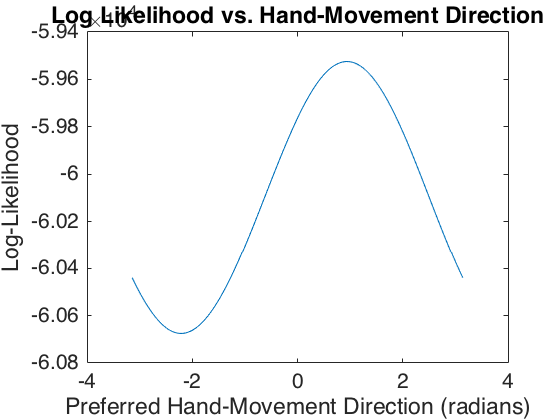

In [31]:
% model is LAMBDA(v,phi) = alpha + b*v/vmax*cos(phi-phi_pref)
% log-likelihood is 
%  log[L(lambda(t))] = {SUM[i=1 to NUM_SPIKES] log(lambda(at spike times))} - 
%     NUM_SPIKES*[alpha*T+beta/vmax*INTEGRAL[0 to T] v*cos(phi-phi_pref)dt]

numSpikes = length(spiketimes);
phi_pref = linspace(-pi,pi,1000);
loglikelihood = zeros(length(phi_pref),1);

alpha = 30;beta = 30;vmax = 16.1; % all in units of seconds (Hz, Hz, cm/sec)

% approximate above integral with numerical integration using composite trapezoidal rule
integral = zeros(length(phi_pref),1);
times = linspace(0,totalTime/1000,length(spikes)); % convert time to units of seconds
for ii=1:length(phi_pref)
    integral(ii) = trapz(times,alpha+(beta/vmax).*V.*cos(phi-phi_pref(ii)));
end

% get SUM log(lambda(at spike times)) and then compute log likelihood
for ii=1:length(phi_pref)
    tempSum = 0;
    for jj=1:numSpikes
        spikeBin = spiketimes(jj);
        tempSum = tempSum+log(alpha+(beta/vmax)*V(spikeBin)*cos(phi(spikeBin)-phi_pref(ii)));
    end
    loglikelihood(ii) = loglikelihood(ii)+tempSum-numSpikes*integral(ii);
end

figure();plot(phi_pref,loglikelihood);
xlabel('Preferred Hand-Movement Direction (radians)');ylabel('Log-Likelihood');
title('Log Likelihood vs. Hand-Movement Direction')

This log-likelihood function is itself a cosine function. This makes sense as the value of phi_preferred is set inside a cosine in the tuning model lambda. The local minimum of the likelihood at ~ -2.5 radians seems to contradict the 200-bin occupancy-normalized histograms from above.

In [32]:
% maximum likelihood estimate and approximate 95% confidence interval

[~,index] = max(loglikelihood);

phi_prefML = phi_pref(index);

% 95% confidence interval
%  the 95% confidence interval is estimated as +/- 1.96 * 1/sqrt(-loglikelihood''(phi_prefML)) 
%  i.e. the second derivative of the loglikelihood evaluated at the maximum likelihood estimator

%  approximate the second derivative with the second-order finite difference equation
%  for discrete data with sampling density h
%   f''(x) = [f(x+1)-2f(x)+f(x-1)] / h*h

h = mean(diff(phi_pref));
secondDeriv = (loglikelihood(index+1)-2*loglikelihood(index)+loglikelihood(index-1))/(h*h);
FisherInfo = -secondDeriv;

standardError = 1.96/sqrt(FisherInfo);
display(sprintf('Maximum Likelihood Estimate for Phi_Preferred: %3.2f +/- %0.3f radians',phi_prefML,standardError));

Maximum Likelihood Estimate for Phi_Preferred: 0.94 +/- 0.081 radians


This estiamte for the neuron's preferred hand-movement direction matches the estimate from the occupancy-normalized histograms. In addition, given only 8 seconds of data, the 95% confidence interval seems very narrow.

# Plot of Lambda_Hat(t)

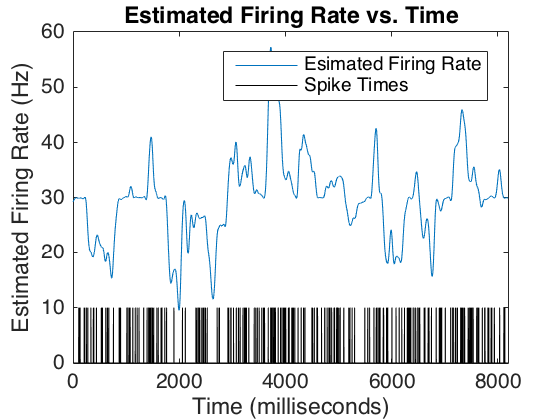

In [33]:
lambdaHat = alpha+(beta/vmax).*V.*cos(phi-phi_prefML);

figure();plot(T,lambdaHat);hold on;
plot(T,spikes.*10,'k');
axis([0 totalTime 0 60]);
xlabel('Time (milliseconds)');ylabel('Estimated Firing Rate (Hz)');
title('Estimated Firing Rate vs. Time');
legend('Esimated Firing Rate','Spike Times');

The estimated firing rate matches the data to some extent but it doesn't seem to be doing a perfect job. For example, at about 5000 milliseconds, there is a high density of spikes while the estimated firing rate remains approximately constant. There might also be a lag component that is missing from the model: the model appears to increase or decrease the firing rate just a few milliseconds too soon. However, the high rate of spiking at about 4000 milliseconds and 7500 milliseconds, and the low rate of spiking at about 2000 milliseconds are all well-reflected by the model.

# Goodness of Fit: Time-Rescaling

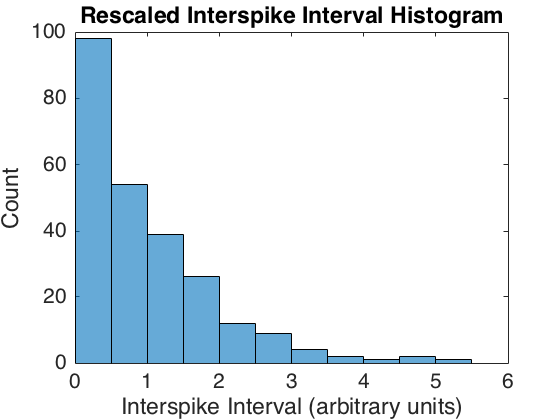

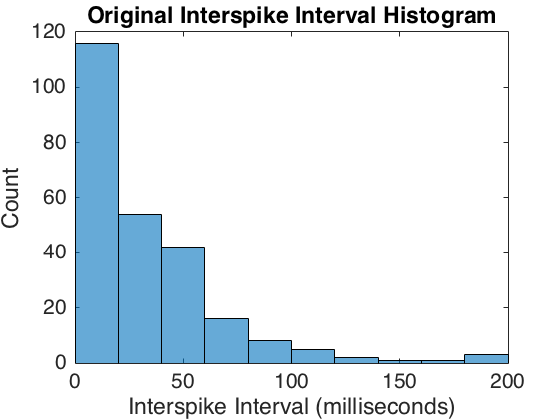

In [34]:
% rescaled waiting times Z_i = INTEGRAL[S_i-1 to S_i] lambdaHat dt

%  adjust the integration scheme from above
Z = zeros(numSpikes,1);
V = [0;V];
phi = [0;phi];
for ii=1:numSpikes
    if ii==1 
        lowerBound = 0;lowerInd = 1;
    else
        lowerBound = spiketimes(ii-1);lowerInd = spiketimes(ii-1)+1;
    end
    upperBound = spiketimes(ii);upperInd = spiketimes(ii)+1;
    times = linspace(lowerBound/1000,upperBound/1000,upperBound-lowerBound+1);
    integrand = alpha+(beta/vmax).*V(lowerInd:upperInd).*cos(phi(lowerInd:upperInd)-phi_prefML);
    if upperInd == lowerInd
        Z(ii) = 0;
    else
       Z(ii) = trapz(times,integrand);
    end
end

origISIs = diff([0;spiketimes]);
figure();histogram(origISIs);xlabel('Interspike Interval (milliseconds)');
ylabel('Count');title('Original Interspike Interval Histogram');

figure();histogram(Z);xlabel('Interspike Interval (arbitrary units)');
ylabel('Count');title('Rescaled Interspike Interval Histogram');

Note: There appear to be some errors between the 'spikes' vector and the 'spiketimes' vector. sum(spikes) = 237 but 'spiketimes' is a 248-by-1 vector.

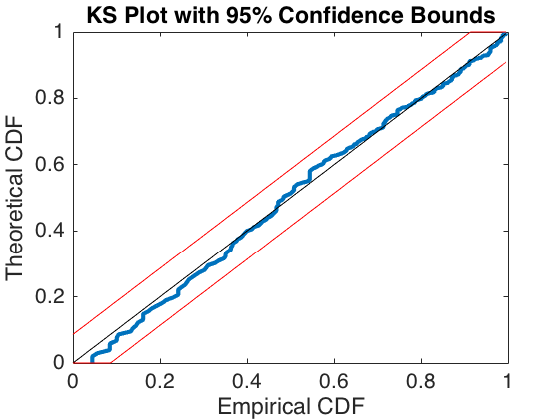

KS statistic: 0.045


In [35]:
% KS plot, theoretical distribution is Z ~ Exp(1)
sortedISIs = sort(Z);
ISItimes = 0:0.01:max(sortedISIs);
eCDF = zeros(length(ISItimes),1);
for ii=1:length(ISItimes)
    eCDF(ii) = sum(sortedISIs <= ISItimes(ii));
end
eCDF = eCDF./numSpikes;

tCDF = 1-exp(-ISItimes');
bounds = (1.36/sqrt(numSpikes)).*ones(length(ISItimes),1);
figure();plot(eCDF,tCDF,'LineWidth',2);hold on;
xlabel('Empirical CDF');ylabel('Theoretical CDF');
title('KS Plot with 95% Confidence Bounds');

plot(tCDF,tCDF,'k');plot(tCDF,min(tCDF+bounds,1),'r');
plot(tCDF,max(tCDF-bounds,0),'r');hold off;

KSstat = max(abs(eCDF-tCDF));

display(sprintf('KS statistic: %3.3f',KSstat));


The fit model passes the KS test for alpha = 0.05, i.e. 95% confidence bounds.  

# Goodness of Fit: Autocorrelation

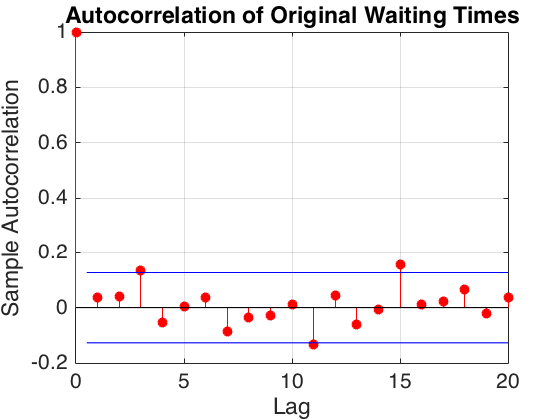

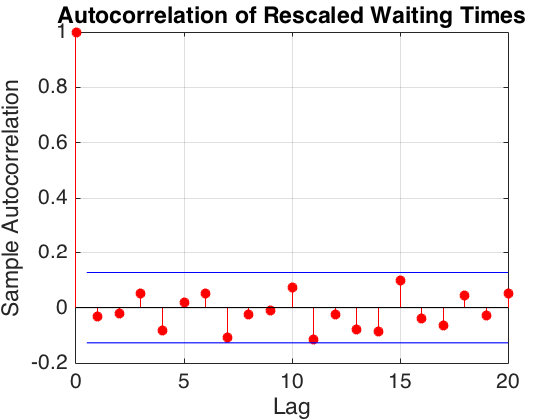

In [36]:
figure();autocorr(Z);title('Autocorrelation of Rescaled Waiting Times');
figure();autocorr(origISIs);title('Autocorrelation of Original Waiting Times');

None of the lags has a significant autocorrelation in the rescaled waiting times autocorrelation, implying that the assumption of independence is not violated according to this measure.

# Goodness of Fit: Fano Factor

In [37]:
tFano = 1;
rescaledSpikes = cumsum(Z);
edges = 0:1:max(rescaledSpikes);
binnedSpikes = histcounts(rescaledSpikes,edges);

numBins = length(binnedSpikes);

sampleFano = var(binnedSpikes)/mean(binnedSpikes);

% for 95% confidence interval
alpha = 0.05;
A = numBins/2;B = 2/numBins;
confInt = [gaminv(alpha/2,A,B),gaminv(1-alpha/2,A,B)];

display(sprintf('Sample Fano Factor for %d Bins: %3.3f',numBins,sampleFano));

display(sprintf('Approximate 95%% Confidence Interval for Inhomogeneous Poisson: %3.3f - %3.3f',confInt(1),confInt(2)));

Sample Fano Factor for 241 Bins: 0.894
Approximate 95% Confidence Interval for Inhomogeneous Poisson: 0.829 - 1.186


The sample Fano Factor falls within the 95% conifdence interval for the spiking activity of a time-rescaled inhomogeneous Poisson process. This suggests, in accordance with the KS plot and the sample autocorrelation function, that the inhomogeneous Poisson process with tuning model lambda is a good fit for the data.

# Conclusions

The firing properties of this neuron from primary motor cortex are well-described by the model, though not perfectly so. The model passed the KS test for the rescaled waiting times of an inhomogeneous Poisson process, did not break the assumption of independent rescaled waiting times, and had a sample Fano factor well within the bounds of the 95% confidence interval for an inhomogeneous Poisson process. Even still, the model does not seem to capture all features of the data. The occupancy-normalized histograms showed some evidence of periodicity with frequency ~pi, but the model requires the preferred direction to have a periodicity of 2pi. Adding another parameter to the model to account for different periodicities, as mentioned above, may improve goodness of fit. Finally, a lag might be incorporated into the model to reflect the time that the signal takes to get from primary motor cortex to the animal's hand. A fuller model might take the form:

LAMBDA(v,phi) = alpha + (beta/vmax)*v(t+lag)*cos(gamma*phi(t+lag)-phi_pref) ,

where we would would now estimate phi_preferred, lag, and gamma using maximum likelihood estimation. This model, however, is not causal. We would have to know the hand-movement velocity in the future to infer a firing rate in the past. Depending on the goal of creating the model, a non-causal firing rate function such as this may or may not be appropriate.